# Deblurring di immagini mosse

Il progetto riguarda il deblurirng di immagini. Il tipo di "blur" in questione è ottenuto mediante sovrapposizione di immagini leggermente traslate a partire dall'originale, lungo un tragitto randomico.

Questo tipo di blur ntende simulare il risultato del tremolio della mano per riprese con tempo di esposizione prolungato.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Lavoriamo da immagini ottenute a partire da MNIST.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)

print(x_test.shape)
print(x_train.shape)

(10000, 28, 28)
(60000, 28, 28)


Qui viene fornito il generatore che dovete utilizzare per il vostro progetto.
Non modificate in numero di mosse (10), nè il range della traslazione.

Siete liberi di modificare a piacimento la batchsize. Utilizzate x_train per il training e x_valid per la validazione.

In [ ]:
def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)


In [ ]:
my_gen = generator(x_train,5)

In [ ]:
def plot(x,y):
  no = x.shape[0]
  print(no)
  plt.figure(figsize=(2*no, 4))
  for i in range(no):
    # display original
    ax = plt.subplot(2, no, i + 1)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, no, i + 1 + no)
    plt.imshow(y[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Qui potete vedere alcuni esempi restituiti dal generatore
Here we plot some examples. In the first row you see the blurred image, and in the second the original image, that is the ground truth that you are suppose to obtain through deblurring.

5


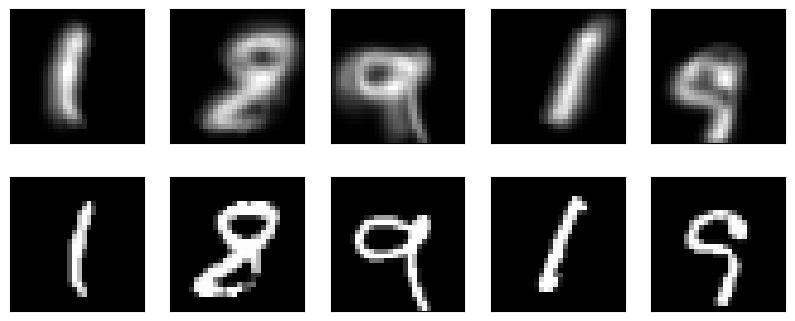

In [ ]:
test_x,test_y = next(my_gen)
plot(test_x,test_y)

# Valutazione

Utilizzate Mean Squared Error (mse) per valutare l'errore tra l'immagine deblurred e la ground truth.

Misurate l' mse su 10000 immagini blurred ottenute dal validation set.

Ripetete la computazione precedente per 10 volte, e fornite come risutato la
**media dei 10 round, unitamente alla deviazione standard**.


# Cosa consegnare
Il lavoro deve essere scolto in keras/tensorflow. Consegnate un singolo notebook dove dovete conservare traccia del training.

Discutete e motivate l'architettura finale, cosi come la scelta dei principali iperparametri.

# Progetto - Creazione della rete neurale

### Funzioni per la creazione degli strati convoluzionali
Per creare gli strati convoluzionali ho usato una funzione che prende in input vari parametri utili per la creazione degli strati.

La funzione è stata creata per rendere più semplice la creazione degli strati e per poterli modificare più facilmente.
Per i vari strati ho scelto di utilizzare la funzione di attivazione ReLU, con la quale ho ottenuto i risultati migliori rispetto ad altre funzioni testate come la LeakyReLU, la PReLU o la sigmoide.
Inoltre ho deciso anche di inserire lo strato di BatchNormalization, che ha lo scopo di normalizzare i valori dei vari layer, permettendomi di migliorare i risultati del modello

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,\
      Input, UpSampling2D, ReLU, BatchNormalization, Conv2DTranspose,\
      Concatenate, Dropout, Reshape, LeakyReLU, ZeroPadding2D, Cropping2D, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2

(projectX, projectY) = next(generator(x_train,300000))

def build_convolutional(x, filters, kernel_size, strides=1, dropout = 0, regularizer = 0, relu = True):
    x = Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding='same',
        kernel_regularizer=l2(regularizer))(x)
    x = BatchNormalization()(x)
    if(relu):
      x = ReLU()(x)
    if dropout > 0:
      x = Dropout(dropout)(x)
    return x

def build_deconvolutional(x, filters, kernel_size, strides=1, dropout = 0, regularizer = 0, relu = True):
    x = Conv2DTranspose(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding='same',
        kernel_regularizer=l2(regularizer))(x)
    x = BatchNormalization()(x)
    if relu:
        x = ReLU()(x)
    if dropout > 0:
        x = Dropout(dropout)(x)
    return x

### Funzione per la creazione dei layer di Inception
In questo caso a partire dallo strato precedente creo un layer di inception che unisce le informazioni ottenute da 4 strati, tutti con combinazioni diverse di kernel, insieme ad uno strato di Max pooling, questo per poter ottenere informazioni da diverse scale.

Per ottenere risultati con la stessa dimensione ho utilizzato stride = 2 per gli strati convoluzionali in modo da dimezzare la dimensione dell'immagine e risultare uguali a quelli dello strato di Max pooling.

- x
  - x1
    - x11
    - x12
  - x2
    - x21
    - x22
  - maxpooling

Dopodicchè unisco i risultati ottenuti dagli strati x11, x12, x21, x22 e maxpooling tramite la funzione `Concatenate` e applico la funzione di attivazione ReLU.

In [ ]:
def build_inception(x, filters, strides=2):
    x1 = build_convolutional(x, filters, 1)
    x11 = build_convolutional(x1, filters, 3, strides = strides, relu=False)
    x12 = build_convolutional(x1, filters, 5, strides = strides, relu=False)

    x2 = build_convolutional(x, filters, 3)
    x21 = build_convolutional(x2, filters, 5, strides = strides, relu=False)
    x22 = build_convolutional(x2, filters, 3, strides= strides, relu=False)

    maxPooling = MaxPooling2D((2, 2), padding='same')(x)

    x = Concatenate()([x11, x12, maxPooling, x21, x22])
    x = ReLU()(x)
    return x

### Funzione per la creazione dell'attenzione sui canali
La funzione implementa il meccanismo dell'attenzione tra i layer. Utilizza un Multi-Layer Perceptron (MLP) per apprendere pesi di attenzione per ciascun canale della feature map. Il Global Average Pooling è utilizzato per comprimere le informazioni spaziali, e i pesi di attenzione ottenuti tramite un MLP sono applicati per enfatizzare canali più rilevanti e diminuire l'importanza di quelli meno rilevanti.

In [ ]:
from tensorflow.keras.layers import Dense, Reshape, GlobalAveragePooling2D, multiply

def build_attention(feature_map, ratio=8):
    channel = feature_map.shape[-1]

    shared_layer_one = Dense(channel//ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=False)

    avg_pool = GlobalAveragePooling2D()(feature_map)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    attention = tf.nn.sigmoid(avg_pool)

    feature_map_with_attention = multiply([feature_map, attention])

    return feature_map_with_attention

### Funzione per la gestione del learning rate
Come ottimizzatore ho deciso di usare Adam, con il quale ho ottenuto i risultati migliori e come learning rate iniziale ho deciso di usare 0.0013.

Per gestire il learning rate ho creato una funzione che prende in input il numero di epoche e il learning rate, la quale viene usata nel training del modello in modo da poter diminuire il learning rate dopo un certo numero di epoche. Ho scelto di partire dalla quinta epoca con la riduzione per poi modificarlo ogni 2 epoche, questo mi è stato molto di aiuto per permettere al modello di convergere correttamente nelle fasi avanzate dell'allenamento.

In [ ]:
from keras.optimizers import SGD, Adam, AdamW, RMSprop,schedules
from tensorflow.keras.callbacks import LearningRateScheduler

adam = Adam(learning_rate=0.0013)

decreaseMultiplier = 0.7

def scheduler(epoch, lr):
  if epoch < 4:
    return lr
  elif ((epoch % 2) == 0):
    return lr * decreaseMultiplier
  else:
    return lr

### Creazione del modello
Il modello è stato creato partendo da un modello autoencoder, utilizzando strati convoluzionali e strati di MaxPooling e di UpSampling. Per ottimizzare il modello inoltre ho deciso di integrare degli strati di **Inception** nell'encoder e applicato la tecnica delle **Skip Connections** nel decoder per migliorare la qualità dell'immagine che genera il modello.
L'idea di utilizzare gli inception mi sembrava un po' azzardata ma cercando su internet ho avuto conferma leggendo un articolo, preso dal seguente [link](https://scholar.colorado.edu/downloads/xg94hp83v) (il link scarica direttamente il pdf), che mi ha convinto a provarli.

Un ulteriore miglioramento è stato ottenuto usando degli attention layer, che permettono di dare più importanza ad alcune parti dell'immagine. Questi layer sono stati posizionati dopo gli strati di Skip Connection e di Inception per massimizzare l'efficacia.

Come numeri di filtri ho scelto di usare da 32 a 256 in modo da permettere al modello di catturare le caratteristiche dell'immagine a vari livelli di astrazione. Invece per la dimensione dei kernel ho scelto di usare sempre la 3x3, in quanto anche con kernel più grandi non si ottenevano risultati migliori.

Inoltre nell'ultimo strato non è presente funzione di attivazione in quanto per errore avevo provato senza e avevo ottenuto risultati migliori, quindi ho deciso di lasciarlo così.

In [ ]:
def deblurring_autoencoder():
    autoencoder_input = Input(shape=(28,28,1))
    starter = build_convolutional(autoencoder_input, 32, 3)
    conv_block1 = build_convolutional(starter, 64, 3)
    conv_block2 = build_inception(conv_block1, 64)
    attention1 = build_attention(conv_block2)
    conv_block3 = build_convolutional(attention1, 128, 3)
    conv_block4 = build_inception(conv_block3, 128)
    attention2 = build_attention(conv_block4)
    conv_block5 = build_convolutional(attention2, 256, 3)

    deconv_block1 = build_deconvolutional(conv_block5, 256, 3)
    upSampling1 = UpSampling2D((2,2))(deconv_block1)
    deconv_block2 = build_deconvolutional(upSampling1, 128, 3)
    merge2 = Concatenate()([deconv_block2, conv_block3])
    attention3 = build_attention(merge2)
    deconv_block3 = build_deconvolutional(attention3, 128, 3)
    upSampling3 = UpSampling2D((2,2))(deconv_block3)
    deconv_block4 = build_deconvolutional(upSampling3, 64, 3)
    deconv_block5 = build_deconvolutional(deconv_block4, 64, 3)
    merge5 = Concatenate()([deconv_block5, conv_block1])
    attention4 = build_attention(merge5)
    deconv_block6 = build_deconvolutional(attention4, 32, 3)

    final_deconv = Conv2DTranspose(filters=1, kernel_size=3,padding='same')(deconv_block6)
    return Model(autoencoder_input, final_deconv)

input_shape = (28, 28, 1)
autoencoder = deblurring_autoencoder()

In [ ]:
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_16 (Conv2D)          (None, 28, 28, 32)           320       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_22 (Ba  (None, 28, 28, 32)           128       ['conv2d_16[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_16 (ReLU)             (None, 28, 28, 32)           0         ['batch_normalization_22

### Training del modello
Nel training ho deciso di eseguire 15 epoche con un batch size di 32, che utilizza l'insieme delle immagini di training ma mescolate in modo da non avere sempre le stesse immagini. Per quanto riguarda il dataset di validazione ho deciso di utilizzare 1000 immagini, generate dal set di test, in modo da poter capire come si comporta il modello durante il training.

In [ ]:
autoencoder.compile(
    optimizer=adam,
    loss='mse',
    metrics=['accuracy', 'mae'])

test_x,test_y = next(generator(x_test,1000))

history = autoencoder.fit(
    projectX,
    projectY,
    steps_per_epoch=4000,
    epochs=15,
    shuffle = True,
    callbacks=[LearningRateScheduler(scheduler)],
    validation_data=(test_x, test_y))



Epoch 1/15
4000/4000 [==============================] - 207s 36ms/step - loss: 0.0090 - accuracy: 0.8136 - mae: 0.0405 - val_loss: 0.0044 - val_accuracy: 0.8124 - val_mae: 0.0285 - lr: 0.0013
Epoch 2/15
4000/4000 [==============================] - 147s 37ms/step - loss: 0.0029 - accuracy: 0.8153 - mae: 0.0222 - val_loss: 0.0034 - val_accuracy: 0.8128 - val_mae: 0.0223 - lr: 0.0013
Epoch 3/15
4000/4000 [==============================] - 145s 36ms/step - loss: 0.0021 - accuracy: 0.8155 - mae: 0.0181 - val_loss: 0.0027 - val_accuracy: 0.8126 - val_mae: 0.0198 - lr: 0.0013
Epoch 4/15
4000/4000 [==============================] - 145s 36ms/step - loss: 0.0016 - accuracy: 0.8155 - mae: 0.0153 - val_loss: 0.0017 - val_accuracy: 0.8129 - val_mae: 0.0152 - lr: 0.0013
Epoch 5/15
4000/4000 [==============================] - 145s 36ms/step - loss: 0.0012 - accuracy: 0.8156 - mae: 0.0127 - val_loss: 0.0015 - val_accuracy: 0.8130 - val_mae: 0.0130 - lr: 9.1000e-04
Epoch 6/15
4000/4000 [==============

### Visualizzazione grafica del modello

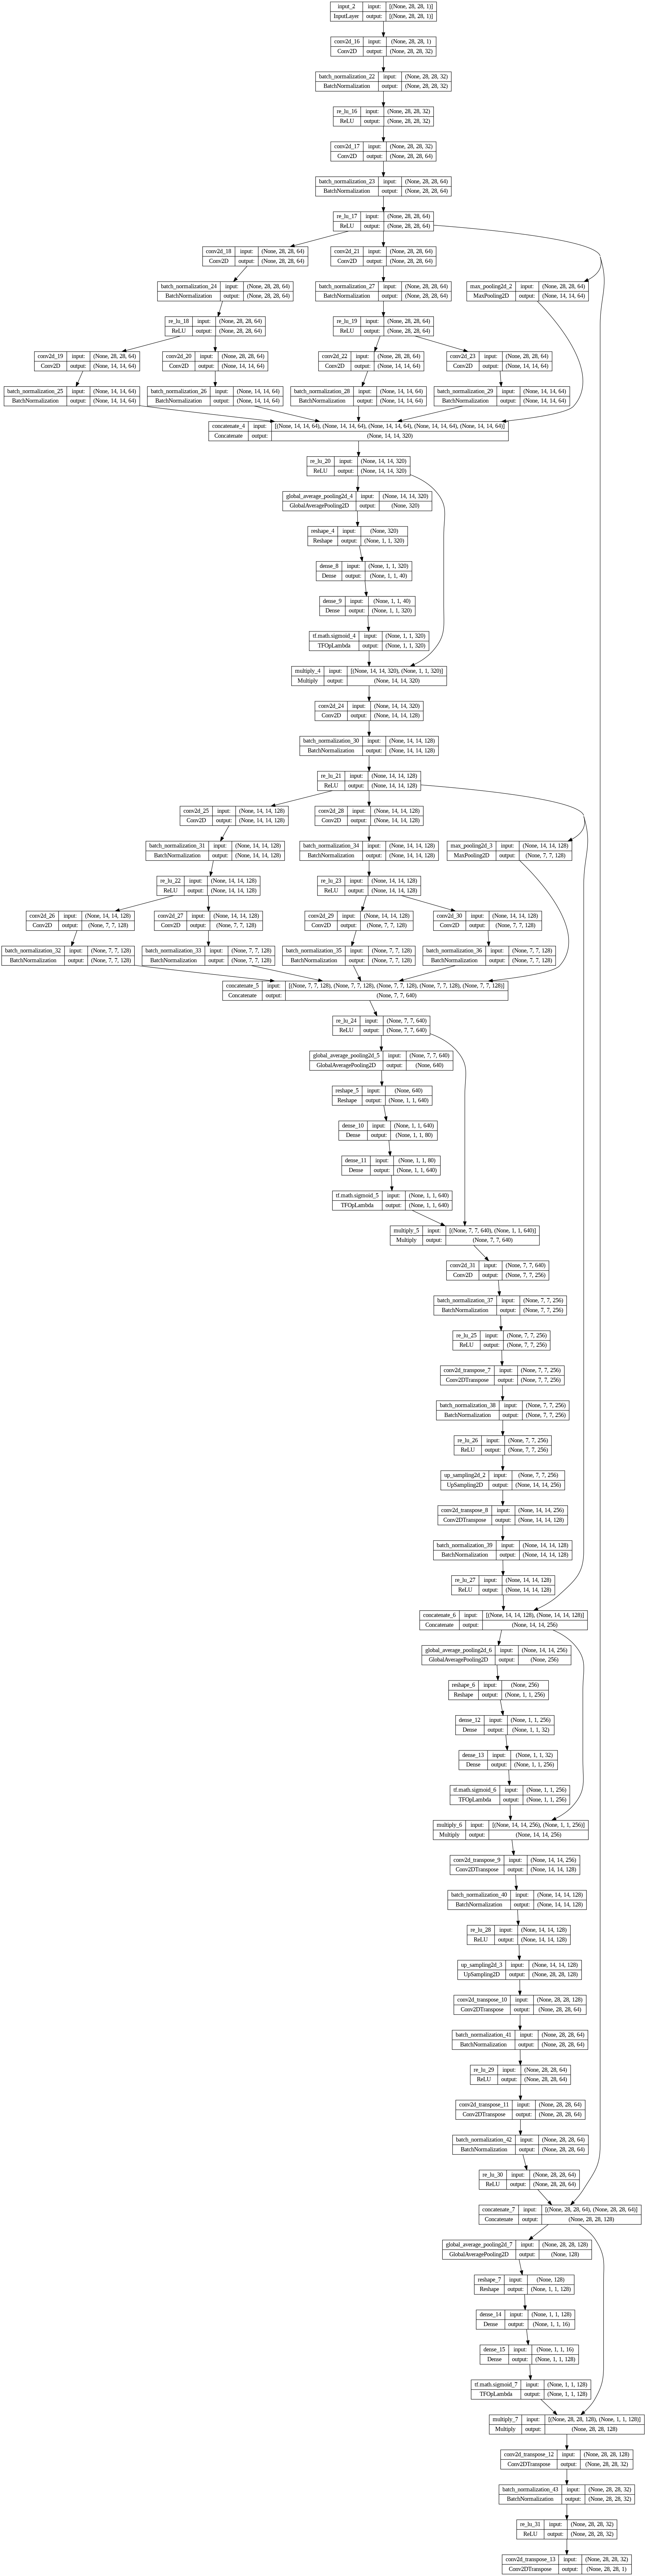

In [ ]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

from IPython.display import Image
Image(filename='autoencoder.png')

### Plot dei dati di training
Nel training del modello ho scelto alcuni metriche per poter valutare la bontà del modello, tra cui: MSE e la MAE

Text(0.5, 0, 'Epoch')

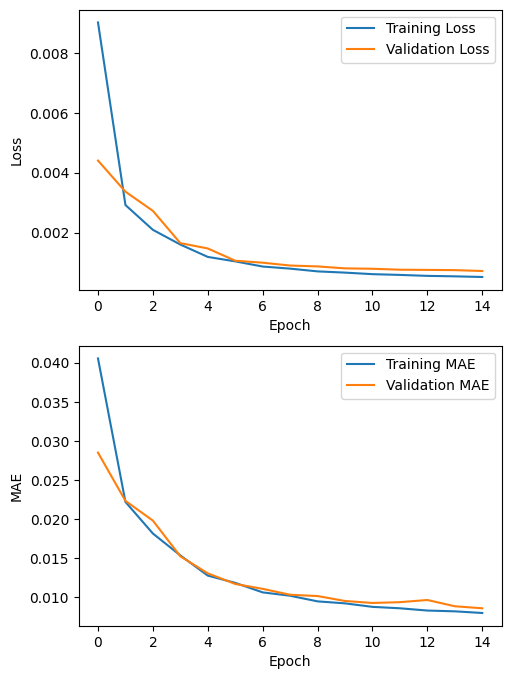

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(2, 2, 3)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='upper right')
plt.ylabel('MAE')
plt.xlabel('Epoch')

### Test del modello
Per testare il modello come richiesto dalla consegna ho calcolato la MSE su 10000 immagini generate dal set di test, per ogni iterazione del ciclo.
In più ho scelto di calcolare anche il PSNR e il SSIM per poter avere una valutazione più precisa del modello, oltre alla deviazione standard del MSE.  

313/313 [==============================] - 3s 11ms/step


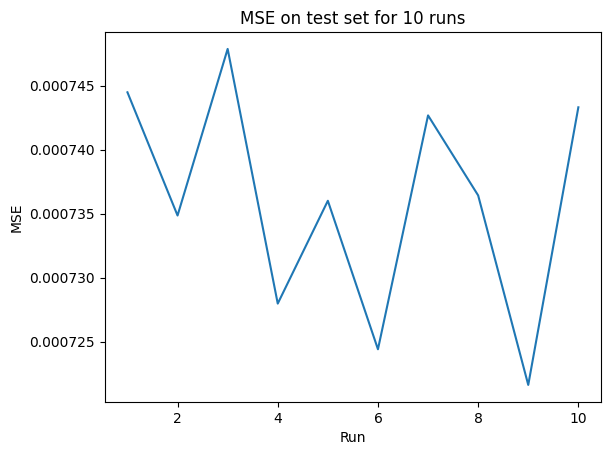

MSE medio:  0.00073595915
Deviazione standard:  8.478832e-06
PSNR: 31.331752129960147
SSIM Index: 0.9950669231936778


In [ ]:
import tensorflow as tf
from skimage import metrics

mse_calculator = tf.keras.losses.MeanSquaredError()
all_mse_scores = []
n_run = 10
psnr = 0;
ssim_index = 0;

for i in range(n_run):
    test_x,test_y = next(generator(x_test,10000))
    pred_subset = autoencoder.predict(test_x)
    test_y = tf.expand_dims(test_y, axis=-1)

    mse_score = mse_calculator(test_y,pred_subset).numpy()
    all_mse_scores.append(mse_score)

    test_y_squeezed = tf.squeeze(test_y).numpy()
    pred_subset_squeezed = tf.squeeze(pred_subset).numpy()

    psnr += metrics.peak_signal_noise_ratio(test_y_squeezed, pred_subset_squeezed)
    ssim_index += metrics.structural_similarity(test_y_squeezed, pred_subset_squeezed)

runs = np.arange(1,11)
plt.plot(runs,all_mse_scores)
plt.xlabel('Run')
plt.ylabel('MSE')
plt.title('MSE on test set for 10 runs')
plt.show()

np.mean(all_mse_scores)
print("MSE medio: ",np.mean(all_mse_scores))

np.std(all_mse_scores)
print("Deviazione standard: ",np.std(all_mse_scores))

print("PSNR:", psnr / 10)
print("SSIM Index:", ssim_index / 10)

### Confronto tra le immagini generate dal modello e le originali

1/1 [==============================] - 0s 363ms/step
10


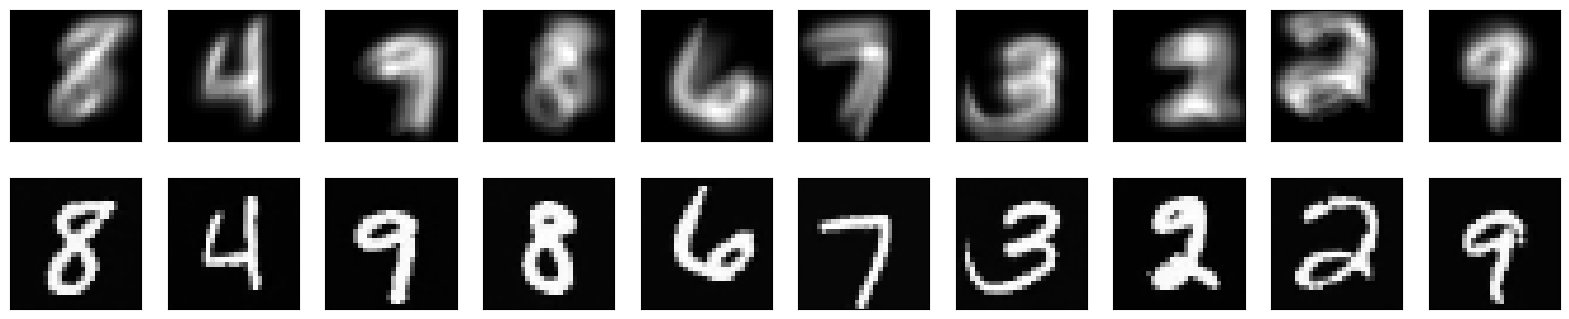

10


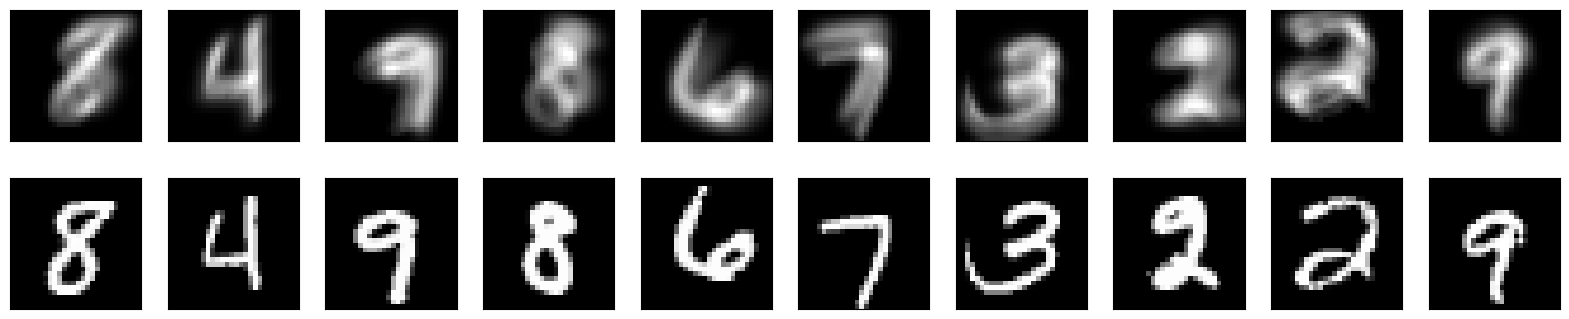

In [ ]:
test_x,test_y = next(generator(x_test,10))
pred_subset = autoencoder.predict(test_x)

plot(test_x, pred_subset)
plot(test_x, test_y)

- Alessandro Testa
- Codice matricola: 0001043390
- Mail: alessandro.testa8@studio.unibo.it